# Tutorial: creating a Q2Q transformation step by step

A Q2Q transformation is a functional relationship between what you have and what you want. It applies to random variables because the relationship is between the quantiles of the input and target random variables.

This tutorial demonstrates how to generate Q2Q functions between modelled (input) and historical (target) renewable generation time series for solar and onshore wind power. Unless stated otherwise, one-year hourly time series will be considered.

Q2Q encapsulates modelling errors statistically and can improve the modelling of renewable generation for tasks related to energy system optimisation. Further details can be found at PyPSA-Spain [seminal paper](https://doi.org/10.1016/j.esr.2025.101764).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import sys
import os
import numpy as np


##### Import local functions
sys.path.append(os.path.abspath(os.path.join('..')))
import funs

## Gather your data

To implement a Q2Q transformation, you basically need two time series:

- the target time series, with historical data, $g_{H,t}$, for a specific year of interest.

- the input time series, with modelled data, $g_{M,t}$, for the same time period.

$t$ refers to time index.

### Historical data

> At the end of this section, the dataframe `df_target` with the input time series must be defined. Indices must be timestamps in UTC, and the column name must be `value`.

Historical data on renewable generation can be difficult to obtain, if not impossible.

Generation time series for Spain can be retrieved at https://api.esios.ree.es/.

This repository includes historical generation time series for Spain over several years, which can be found in folder `data/historical_data/`.

In [ ]:
##### Parameters
carrier = 'onwind'
year = 2023


##### Load target data
df_target = pd.read_csv(f'../data/historical_data/{carrier}_{year}.csv',
                        index_col=0, parse_dates=True)

### Modelled data

> At the end of this section, the dataframe `df_input` with the input time series must be defined. Indices must be timestamps in UTC, and the column name must be `value`.

Wind and solar time series at national level are here modelled with [PyPSA-Spain](https://github.com/cristobal-GC/pypsa-spain).

For modelling accuracy, it is important to use an installed capacity layout for the considered technology that is as close as possible to the existing one in the specified year. In **PyPSA-Spain** you can use the functionality `update_elec_capacities` to specify the installed capacity for a given technology at NUTS-2 level. Data on installed capacity in Spain at NUTS-2 level can be retrieved from https://www.ree.es/es/apidatos.

It is also important to retain all relevant details and hypotheses of the implemented scenario, as different choices may lead to different generation time series. For example:

- Meteorological cutout

- Wind turbine model / PV panel configuration

- Correction factors

- ...

This repository includes modelled generation time series for Spain over several years, which can be found in the folder `data/modelled_data/{analysis}`, where the analysis refer to either the Reference case or one of the sensitivity analyses included in this repository.


In [13]:
##### Parameters
analysis = 'REF'

##### Load input data
df_input = pd.read_csv(f'../data/modelled_data/{analysis}/onwind_REF.csv',
                        index_col=0, parse_dates=True)

df_input['value'] = df_input['q2qNo']

## Compare input and target variables

### Time series

In [14]:
##### Define the date range
start = f'{year}-04-01'
end = f'{year}-04-10'

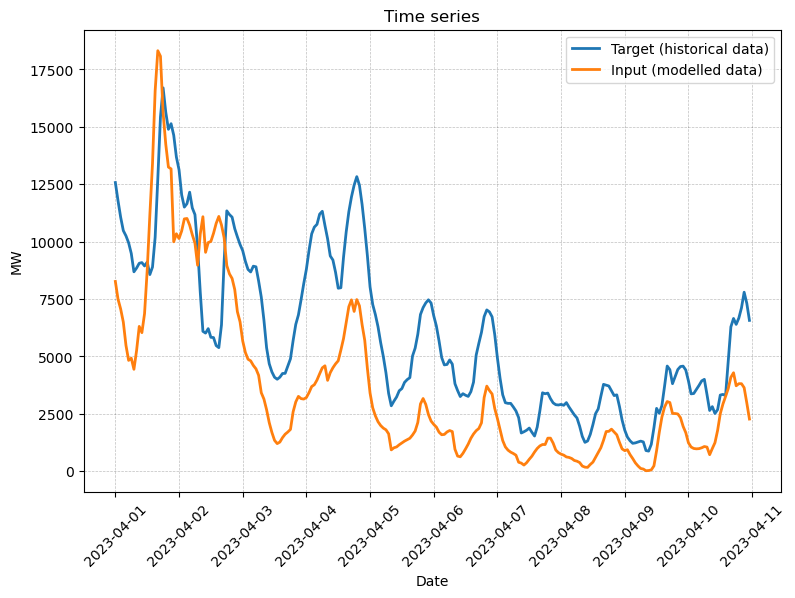

In [15]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(df_target.loc[start:end].index, 
        df_target.loc[start:end]['value'], 
        label='Target (historical data)', 
        linewidth=2)

ax.plot(df_input.loc[start:end].index, 
        df_input.loc[start:end]['value'], 
        label='Input (modelled data)', 
        linewidth=2)

ax.set_title('Time series')
ax.set_xlabel('Date')
ax.set_ylabel('MW')
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

### Probability density functions (PDFs)

In [16]:
##### Define the range of values
x_max = 1.05*max([df_target.max().max(), df_input.max().max()])
x_min = -0.02*x_max
N = 1000
x_values = np.linspace(x_min, x_max, N)

In [17]:
##### Input pdf
kde_input = gaussian_kde(df_input['value'])
kde_input.set_bandwidth(bw_method=kde_input.factor * 0.5)  # re-scale bandwidth

pdf_input = kde_input(x_values)

In [18]:
##### Target pdf
kde_target = gaussian_kde(df_target['value'])
kde_target.set_bandwidth(bw_method=kde_target.factor * 0.5)  # re-scale bandwidth

pdf_target = kde_target(x_values)

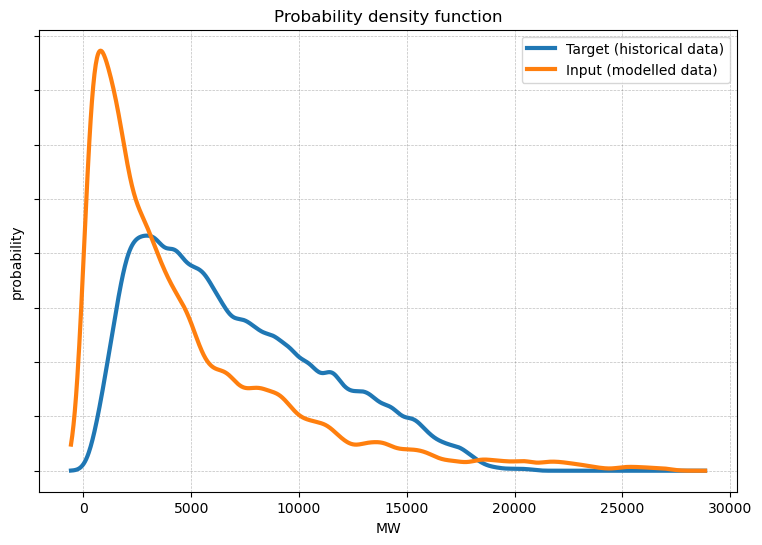

In [19]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(x_values, pdf_target, label='Target (historical data)', linewidth=3)
ax.plot(x_values, pdf_input, label='Input (modelled data)', linewidth=3)

ax.set_title('Probability density function')
ax.set_xlabel('MW')
ax.set_ylabel('probability')
ax.set_yticklabels([])
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)


### Duration curves

In [20]:
##### Duration curves
sorted_target = df_target['value'].sort_values(ascending=False).reset_index(drop=True)
sorted_input = df_input['value'].sort_values(ascending=False).reset_index(drop=True)

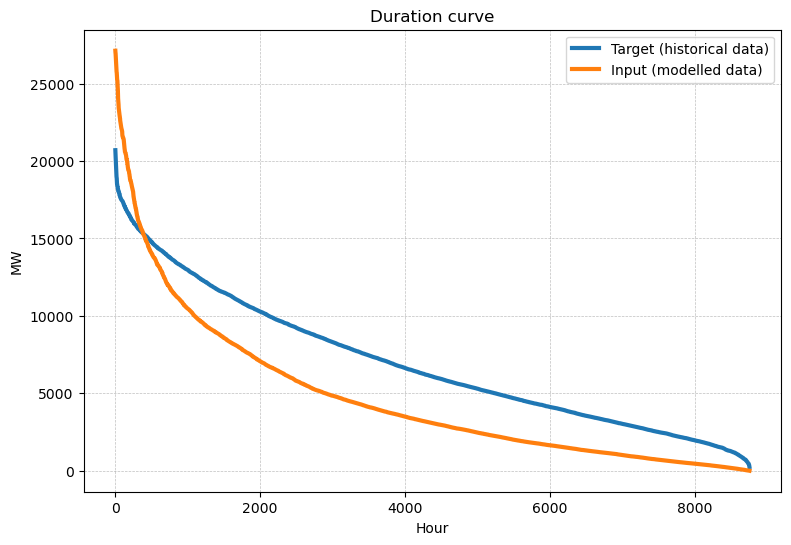

In [21]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(sorted_target.values, label='Target (historical data)', linewidth=3)
ax.plot(sorted_input.values, label='Input (modelled data)', linewidth=3)

ax.set_title('Duration curve')
ax.set_xlabel('Hour')
ax.set_ylabel('MW')
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)


### target-vs-input

Use colours according to date to reveal potential seasonalities.

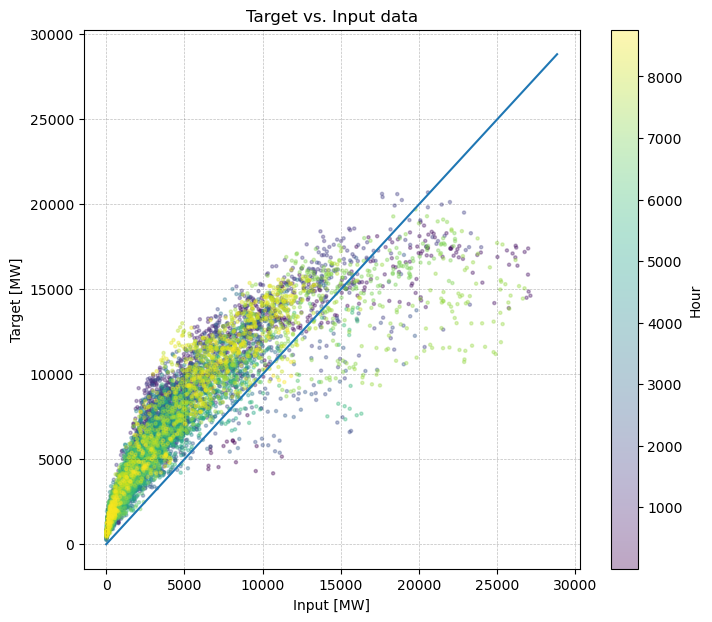

In [22]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(8,7))

color_values = range(1, len(df_input) + 1)

plt.scatter(df_input['value'], df_target['value'], 
            c=color_values,
            s = 5,
            alpha=0.35)

ax.set_title('Target vs. Input data')
ax.set_xlabel('Input [MW]')
ax.set_ylabel('Target [MW]')
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

# Colorbar
plt.colorbar(label='Hour')

# Line at 45º
x_max = 1.05*max([df_input.max().max(),df_target.max().max()])
plt.plot([0, x_max],[0, x_max])



## Normalise input and target variables

Both the input and target time series are normalised prior to computing the Q2Q transformation. Since the obtained transformation stems from national level data, but will be apply in PyPSA-Spain at cluster level, normalisation is required. Three normalisation schemes are proposed here, see details in the [seminal paper](https://doi.org/10.1016/j.esr.2025.101764):

- **Normalisation scheme (1)**:
      normalise both with the installed capacity.

- **Normalisation scheme (2)**:
      normalised both input and target with the maximum value attained by both 
      of them.

- **Normalisation scheme (3)**:
      normalise input with its maximum and target with its maximum.



In [23]:
########## Normalisation scheme (1)
df_capacity = pd.read_csv('../data/installed_capacity.csv', index_col='year')
installed_capacity = df_capacity.at[year, carrier]

df_input_norm1 = df_input.div(installed_capacity)
df_target_norm1 = df_target.div(installed_capacity)

In [24]:
########## Normalisation scheme (2)
x_max = max([df_input.max().max(),df_target.max().max()])

df_input_norm2 = df_input.div(x_max)
df_target_norm2 = df_target.div(x_max)

In [25]:
########## Normalisation scheme (3)
input_max = df_input.max().max()
target_max = df_target.max().max()

df_input_norm3 = df_input.div(input_max)
df_target_norm3 = df_target.div(target_max)    

Take a look at the impact of the normalisation scheme on the PDFs and the duration curves.

In [26]:
dict_dfs = {
    'df_input_norm1': df_input_norm1,
    'df_input_norm2': df_input_norm2,
    'df_input_norm3': df_input_norm3,
    'df_target_norm1': df_target_norm1,
    'df_target_norm2': df_target_norm2,
    'df_target_norm3': df_target_norm3,
}

### PDFs

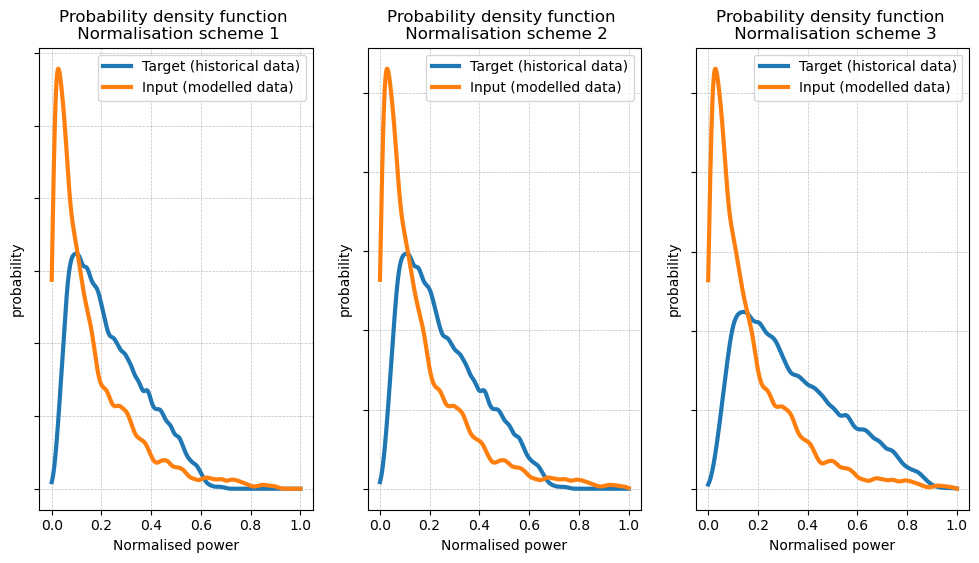

In [27]:
fig, axes = plt.subplots(1,3,figsize=(12,6))


for i, ax in enumerate(axes):

    df_input = dict_dfs[f'df_input_norm{i+1}']
    df_target = dict_dfs[f'df_target_norm{i+1}']


    ##### Define the range of values
    x_max = 1
    x_min = 0
    N = 1000
    x_values = np.linspace(x_min, x_max, N)

    ##### Input pdf
    kde_input = gaussian_kde(df_input['value'])
    kde_input.set_bandwidth(bw_method=kde_input.factor * 0.5)  # re-scale bandwidth

    pdf_input = kde_input(x_values)

    ##### Target pdf
    kde_target = gaussian_kde(df_target['value'])
    kde_target.set_bandwidth(bw_method=kde_target.factor * 0.5)  # re-scale bandwidth

    pdf_target = kde_target(x_values)

    ##### Figure
    ax.plot(x_values, pdf_target, label='Target (historical data)', linewidth=3)
    ax.plot(x_values, pdf_input, label='Input (modelled data)', linewidth=3)

    ax.set_title(f'Probability density function \n Normalisation scheme {i+1}')
    ax.set_xlabel('Normalised power')
    ax.set_ylabel('probability')
    ax.set_yticklabels([])
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)



### Duration curves

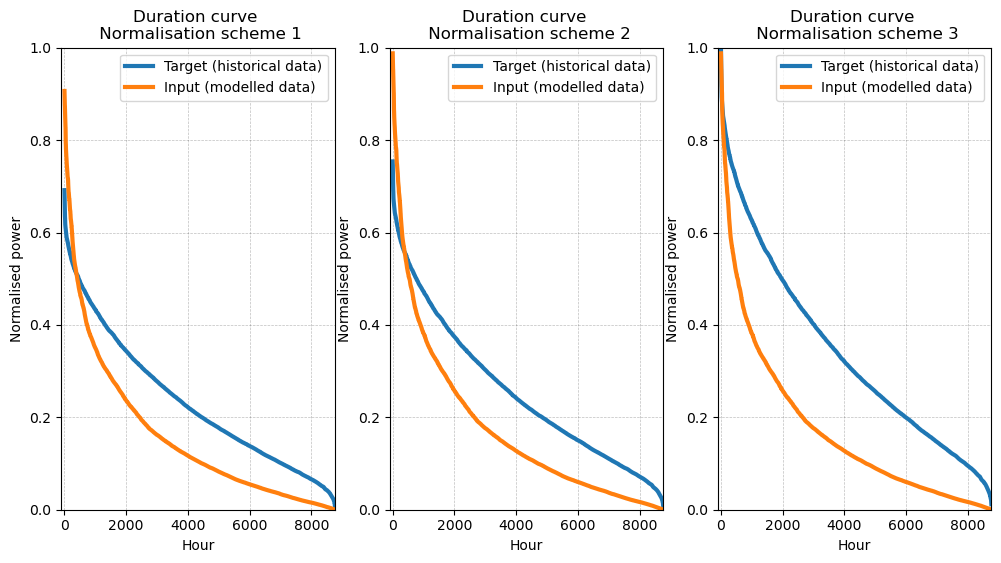

In [28]:
fig, axes = plt.subplots(1,3,figsize=(12,6))


for i, ax in enumerate(axes):

    df_input = dict_dfs[f'df_input_norm{i+1}']
    df_target = dict_dfs[f'df_target_norm{i+1}']


    ##### Duration curves
    sorted_target = df_target['value'].sort_values(ascending=False).reset_index(drop=True)
    sorted_input = df_input['value'].sort_values(ascending=False).reset_index(drop=True)

    ##### Figure
    ax.plot(sorted_target.values, label='Target (historical data)', linewidth=3)
    ax.plot(sorted_input.values, label='Input (modelled data)', linewidth=3)

    ax.set_title(f'Duration curve \n Normalisation scheme {i+1}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Normalised power')
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

    ax.set_xlim(-100, 8760)
    ax.set_ylim(0, 1)


## Compute the Q2Q transformation

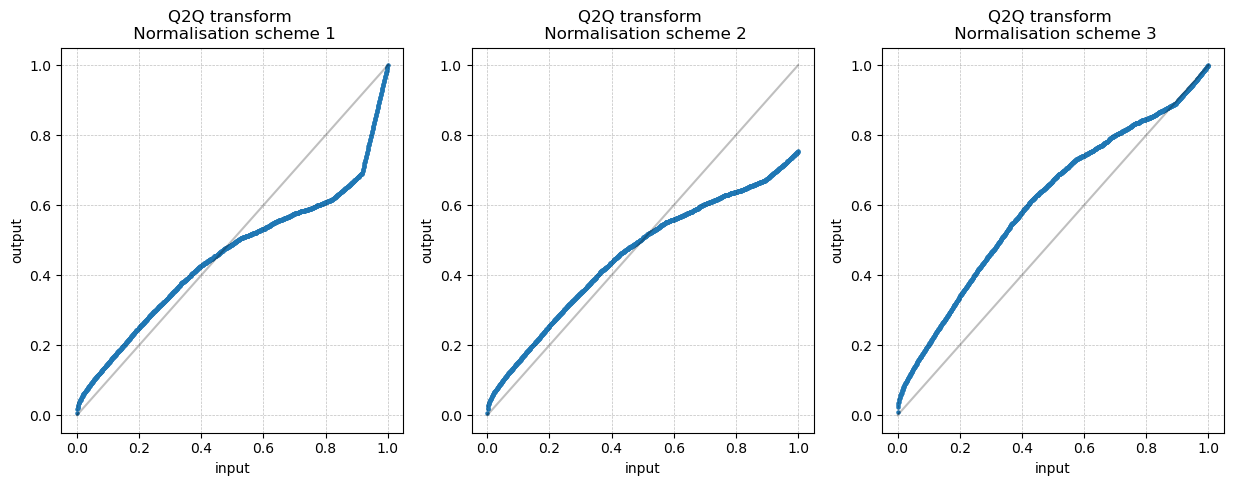

In [33]:
fig, axes = plt.subplots(1,3,figsize=(15,5))


for i, ax in enumerate(axes):

    ##### Select data
    df_input = dict_dfs[f'df_input_norm{i+1}']
    df_target = dict_dfs[f'df_target_norm{i+1}']


    ##### Get the Q2Q transform
    q2q_transform = funs.fun_q2q_transform(df_input, df_target)


    ##### Plot the Q2Q transform
    x_values = np.linspace(0, 1, 1000)
    y_values = q2q_transform(x_values)

    ax.scatter(x_values,y_values,s=5)
    ax.plot([0, 1],[0, 1],color='black',alpha=0.25)

    ax.set_title(f'Q2Q transform \n Normalisation scheme {i+1}')
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)